# Alpamayo-R1 Demo

This notebook will load some example data from the NVIDIA [PhysicalAI-AV Dataset](https://huggingface.co/datasets/nvidia/PhysicalAI-Autonomous-Vehicles) and run the Alpamayo-R1 model on it, producing and visualizing output trajectories and associated reasoning traces.

In [1]:
import copy
import numpy as np
import mediapy as mp
import pandas as pd

import torch
from alpamayo_r1.models.alpamayo_r1 import AlpamayoR1
from alpamayo_r1.load_physical_aiavdataset import load_physical_aiavdataset
from alpamayo_r1 import helper

### Load model and construct data preprocessor

In [2]:
model = AlpamayoR1.from_pretrained("nvidia/Alpamayo-R1-10B", dtype=torch.bfloat16).to("cuda")
processor = helper.get_processor(model.tokenizer)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Load and prepare data

In [3]:
clip_ids = pd.read_parquet("clip_ids.parquet")["clip_id"].tolist()
clip_id = clip_ids[774]
# clip_id = '030c760c-ae38-49aa-9ad8-f5650a545d26'

data = load_physical_aiavdataset(clip_id)

messages = helper.create_message(data["image_frames"].flatten(0, 1))

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=False,
    continue_final_message=True,
    return_dict=True,
    return_tensors="pt",
)
print("seq length:", inputs.input_ids.shape)
model_inputs = {
    "tokenized_data": inputs,
    "ego_history_xyz": data["ego_history_xyz"],
    "ego_history_rot": data["ego_history_rot"],
}
model_inputs = helper.to_device(model_inputs, "cuda")

seq length: torch.Size([1, 3006])


### Model inference

In [23]:
torch.cuda.manual_seed_all(42)
with torch.autocast("cuda", dtype=torch.bfloat16):
    pred_xyz, pred_rot, extra = model.sample_trajectories_from_data_with_vlm_rollout(
        data=copy.deepcopy(model_inputs),
        top_p=0.90,
        temperature=0.8,
        num_traj_samples=5,  # Feel free to raise this for more output trajectories and CoC traces.
        max_generation_length=256,
        return_extra=True,
    )

# the size is [batch_size, num_traj_sets, num_traj_samples]
print("Chain-of-Causation (per trajectory):\n", extra["cot"][0])

Chain-of-Causation (per trajectory):
 [['Nudge to the left to increase clearance from the construction cones encroaching into the lane.'
  'Nudge to the left to increase clearance from the construction equipment on the right.'
  'Keep distance to the lead vehicle because it is moving slowly ahead.'
  'Keep distance to the lead vehicle because it is moving slowly ahead in the same lane.'
  'Keep distance to the lead vehicle since it is moving slowly ahead.']]


## Visualizing data and results

,,,
,,,
,,,
,,,

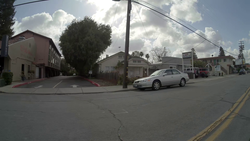
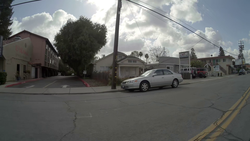
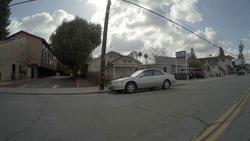
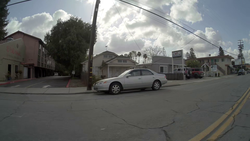
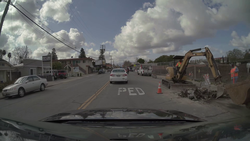
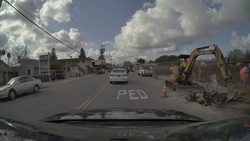
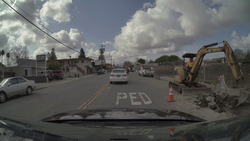
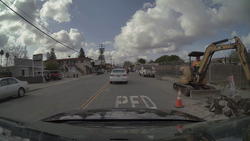
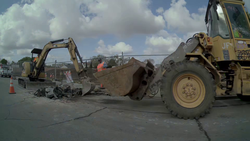
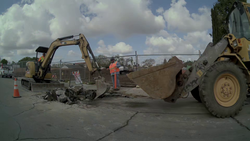
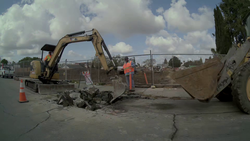
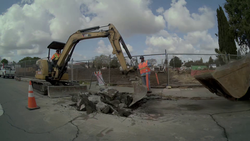
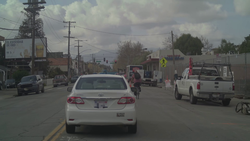
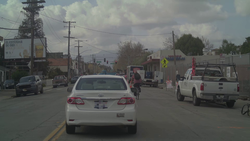
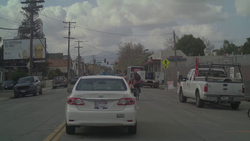
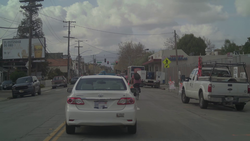

In [6]:
mp.show_images(data["image_frames"].flatten(0, 1).permute(0, 2, 3, 1), columns=4, width=250)

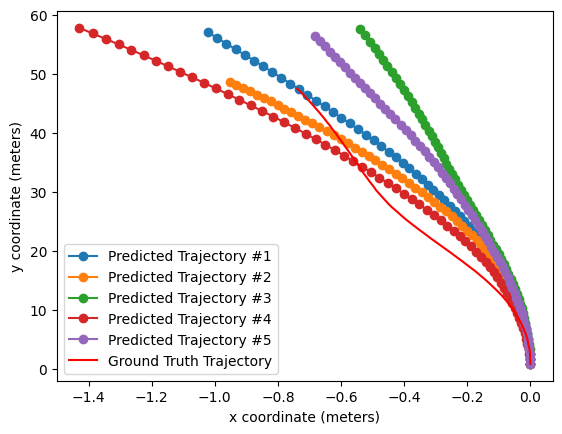

In [20]:
import matplotlib.pyplot as plt


def rotate_90cc(xy):
    # Rotate (x, y) by 90 deg CCW -> (y, -x)
    return np.stack([-xy[1], xy[0]], axis=0)


for i in range(pred_xyz.shape[2]):
    pred_xy = pred_xyz.cpu()[0, 0, i, :, :2].T.numpy()
    pred_xy_rot = rotate_90cc(pred_xy)
    gt_xy = data["ego_future_xyz"].cpu()[0, 0, :, :2].T.numpy()
    gt_xy_rot = rotate_90cc(gt_xy)
    plt.plot(*pred_xy_rot, "o-", label=f"Predicted Trajectory #{i + 1}")

plt.ylabel("y coordinate (meters)")
plt.xlabel("x coordinate (meters)")
plt.plot(*gt_xy_rot, "r-", label="Ground Truth Trajectory")
plt.legend(loc="best")
# plt.axis("equal")
# plt.xlim(-2,1)


In [11]:
pred_xy = pred_xyz.cpu().numpy()[0, 0, :, :, :2].transpose(0, 2, 1)
diff = np.linalg.norm(pred_xy - gt_xy[None, ...], axis=1).mean(-1)
print(diff)
print("minADE:", diff.min(), "meters")

[2.5357628 0.8809358 2.5560646 3.2586355 2.9589486]
minADE: 0.8809358 meters
